<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Boundaries_Segmentation_using_BASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Boundaries Segmentation using BASNet**
https://www.kaggle.com/datasets/balraj98/duts-saliency-detection-dataset

## Introduction

Deep semantic segmentation algorithms have improved a lot recently, but still fails to correctly
predict pixels around object boundaries. In this example we implement
**Boundary-Aware Segmentation Network (BASNet)**, using two stage predict and refine
architecture, and a hybrid loss it can predict highly accurate boundaries and fine structures
for image segmentation.

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/balraj98/duts-saliency-detection-dataset/duts-saliency-detection-dataset.zip

In [ ]:
! pip install keras_cv

In [4]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend

Using TensorFlow backend


#**Prepare The Dataset For Training**

In [5]:
img_size = 288
batch_size = 4
num_classes = 1
train_split = 0.90
data_dir = "/content/DUTS-TE"

In [6]:
os.listdir(data_dir)

['DUTS-TE-Image', 'DUTS-TE-Mask']

In [7]:
def load_path(path, split_ratio):
    images = sorted(glob(os.path.join(data_dir, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(data_dir, "DUTS-TE-Mask/*")))[:140]

    splits = int(len(images) * train_split)
    return (images[: splits], masks[: splits]), (images[splits :], masks[splits :])

def read_data(path, size, mode):
    image = keras.utils.load_img(path, target_size = size, color_mode = mode)
    image = keras.utils.img_to_array(image)
    image = (image / 255.0).astype(np.float32)
    return image

def preprocess(x_data, y_data, img_size, num_classes):
    def f(x, y):
        x, y = x.decode(), y.decode()
        x = read_data(x, size = (img_size, img_size), mode = "rgb")
        y = read_data(y, size = (img_size, img_size), mode = "grayscale")
        return x, y
    images, masks = tf.numpy_function(f, [x_data, y_data], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, num_classes])
    return images, masks

def load_dataset(image_paths, mask_paths, img_size, batch_size, num_classes, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size = 1000)

    dataset = dataset.map(lambda x, y : preprocess(x, y, img_size, num_classes), num_parallel_calls =  tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
train_paths, val_paths = load_path(data_dir, train_split)

train_data = load_dataset(train_paths[0], train_paths[1], img_size, batch_size, num_classes)

valid_data = load_dataset(val_paths[0], val_paths[1], img_size, batch_size, num_classes, shuffle = False)

print(train_data.element_spec)
print(valid_data.element_spec)

(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))


In [9]:
def display_img(images):
    title = ["Input_Img", "True_Mask", "Predict_Mask"]

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(keras.utils.array_to_img(images[i]), cmap = "gray")
        plt.title(title[i])
        plt.axis("off")
    plt.show()

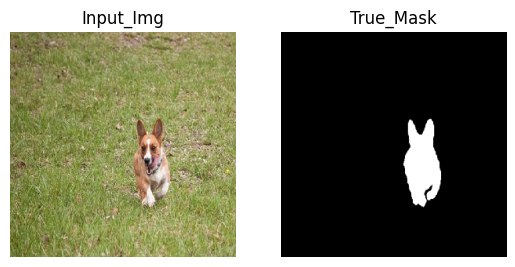

In [10]:
for img, mask in train_data.take(1):
    display_img((img[2], mask[2]))

In [11]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 227
Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  72  73  75  76
  77  78  79  80  82  84  85  86  87  89  90  91  92  93  94  97  98  99
 100 101 102 104 105 107 110 112 113 114 116 117 118 119 120 122 123 125
 126 127 128 129 130 131 133 134 135 137 138 140 141 142 143 144 146 147
 148 149 150 152 153 154 155 156 157 158 159 160 161 162 163 165 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255]


## Building the BASNet Model

BASNet comprises of a predict-refine architecture and a hybrid loss. The predict-refine
architecture consists of a densely supervised encoder-decoder network and a residual refinement
module, which are respectively used to predict and refine a segmentation probability map.

![](https://i.imgur.com/8jaZ2qs.png)

In [12]:
def basic_block(inputs, filters, stride = 1, down_sample = None, Activation = None):
    """Creates a residual(identity) block with two 3*3 convolutions."""
    residual = inputs
    x = layers.Conv2D(filters, kernel_size = (3, 3), strides = stride, padding = "same", use_bias = False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, kernel_size = (3, 3), strides = stride, padding = "same", use_bias = False)(x)
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if Activation is not None:
        x = layers.Activation(Activation)(x)
    return x


def conv_block(inputs, filters, dilation_rate = 1):
    """Apply convolution + batch normalization + relu layer."""
    x = layers.Conv2D(filters, kernel_size = (3, 3), padding = "same", dilation_rate = dilation_rate)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def segmentation_head(inputs, num_classes, final_size):
    """Map each decoder stage output to model output classes."""
    x = layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same")(inputs)

    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)

    return x

def get_resnet_block(resnet, block_num):
    """Extract and return ResNet-34 block."""
    resnet_layers = [3, 4, 6, 3]  # ResNet-34 layer sizes at different block.
    return keras.models.Model(
        inputs=resnet.get_layer(f"v2_stack_{block_num}_block1_1_conv").input,
        outputs=resnet.get_layer(f"v2_stack_{block_num}_block{resnet_layers[block_num]}_add").output,
        name=f"resnet34_block{block_num + 1}")

## Prediction Module

Prediction module is a heavy encoder decoder structure like U-Net. The encoder includes an input
convolutional layer and six stages. First four are adopted from ResNet-34 and rest are basic
res-blocks. Since first convolution and pooling layer of ResNet-34 is skipped so we will use
`get_resnet_block()` to extract first four blocks. Both bridge and decoder uses three
convolutional layers with side outputs. The module produces seven segmentation probability
maps during training, with the last one considered the final output.

In [13]:
def basnet_predict(input_shape, num_classes):
    """BASNet Prediction Module, it outputs coarse label map."""
    filters = 64
    n_stages = 6

    inputs = keras.Input(shape = input_shape)

    # -------------Encoder!--------------
    x = layers.Conv2D(filters, kernel_size = (3, 3), padding = "same")(inputs)
    resnet = keras_cv.models.ResNet34Backbone(include_rescaling = False)

    encoder_block = []
    for i in range(n_stages):
        if i < 4: # First four stages are adopted from ResNet-34 blocks.
            x = get_resnet_block(resnet, i)(x)
            encoder_block.append(x)
            x = layers.Activation("relu")(x)

        else: # Last 2 stages consist of three basic resnet blocks.
            x = layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(x)
            x = basic_block(x, filters = filters * 8, Activation = "relu")
            x = basic_block(x, filters = filters * 8, Activation = "relu")
            x = basic_block(x, filters = filters * 8, Activation = "relu")
            encoder_block.append(x)

    #--------------Bridge!--------------------
    x = conv_block(x, filters = filters * 8, dilation_rate  = 2)
    x = conv_block(x, filters = filters * 8, dilation_rate  = 2)
    x = conv_block(x, filters = filters * 8, dilation_rate  = 2)
    encoder_block.append(x)

    #-------------Decoder!---------------------
    decoder_block = []
    for i in reversed(range(n_stages)):
        if i != (n_stages - 1): # Except first, scale other decoder stages.
            shape = keras.backend.int_shape(x)
            x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)

        x = layers.Concatenate(axis = -1)([encoder_block[i], x])
        x = conv_block(x, filters = filters * 8)
        x = conv_block(x, filters = filters * 8)
        x = conv_block(x, filters = filters * 8)
        decoder_block.append(x)

    decoder_block.reverse()# Change order from last to first decoder stage.
    decoder_block.append(encoder_block[-1]) # Copy bridge to decoder.

    #--------------------Side Outputs!-------------------
    decoder_block = [segmentation_head(decoder_bl, num_classes, input_shape[:2]) for decoder_bl in decoder_block]
    return keras.Model(inputs = [inputs], outputs = decoder_block)

## Residual Refinement Module

Refinement Modules (RMs), designed as a residual block aim to refines the coarse(blurry and noisy
boundaries) segmentation maps generated by prediction module. Similar to prediction module it's
also an encode decoder structure but with light weight 4 stages, each containing one
`convolutional block()` init. At the end it adds both coarse and residual output to generate
refined output.

In [14]:
def basnet_rrm(base_model, num_classes):
    """BASNet Residual Refinement Module(RRM) module, output fine label map."""
    filters = 64
    n_stages = 4

    inputs = base_model.output[0]

    #______________Encoder!_______________

    x = layers.Conv2D(filters, kernel_size = (3, 3), padding = "same")(inputs)

    encoder_block = []
    for _ in range(n_stages):
        x = conv_block(x, filters = filters)
        encoder_block.append(x)
        x = layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(x)

    # _______________Bridge!__________________

    x = conv_block(x, filters = filters)

    # _______________Decoder!__________________

    for i in reversed(range(n_stages)):
        shape = keras.backend.int_shape(x)
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.Concatenate(axis = -1)([encoder_block[i], x])
        x = conv_block(x, filters = filters)

    x = segmentation_head(x, num_classes, None)

    #__________________refined = coarse + residual____________________

    x = layers.Add()([inputs, x]) # Add prediction + refinement output

    return keras.Model(inputs = [base_model.input], outputs = [x])

#Combine predict and refine model...

In [15]:
def basnet(input_shape, num_classes):
    """BASNet, it's a combination of two modules
    Prediction Module and Residual Refinement Module(RRM)."""

    predict_model = basnet_predict(input_shape, num_classes)
    refine_model = basnet_rrm(predict_model, num_classes)

    # combine the outputs
    outputs = [refine_model.output]
    outputs.extend(predict_model.output)

    outputs = [layers.Activation("sigmoid")(i) for i in outputs]
    return keras.Model(inputs = [predict_model.input], outputs = outputs)

## Hybrid Loss

Another important feature of BASNet is its hybrid loss function, which is a combination of
binary cross entropy, structural similarity and intersection-over-union losses, which guide
the network to learn three-level (i.e., pixel, patch and map level) hierarchy representations.

In [16]:
class BasnetLoss(keras.losses.Loss):
    """BASNet hybrid loss."""

    def __init__(self, **kwargs):
        super().__init__(name="basnet_loss", **kwargs)
        self.smooth = 1.0e-9

        # Binary Cross Entropy loss.
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()
        # Structural Similarity Index value.
        self.ssim_value = tf.image.ssim
        #  Jaccard / IoU loss.
        self.iou_value = self.calculate_iou

    def calculate_iou(self, y_true, y_pred):
        """Calculate intersection over union (IoU) between images."""
        intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1, 2, 3])
        union = backend.sum(y_true, [1, 2, 3]) + backend.sum(y_pred, [1, 2, 3])
        union = union - intersection
        return backend.mean((intersection + self.smooth) / (union + self.smooth), axis=0)

    def call(self, y_true, y_pred):
        cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred)

        ssim_value = self.ssim_value(y_true, y_pred, max_val=1)
        ssim_loss = backend.mean(1 - ssim_value + self.smooth, axis=0)

        iou_value = self.iou_value(y_true, y_pred)
        iou_loss = 1 - iou_value

        # Add all three losses.
        return cross_entropy_loss + ssim_loss + iou_loss

In [17]:
basnet_model = basnet(
    input_shape=[img_size, img_size, 3], num_classes = num_classes)
basnet_model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
# Compile model.
basnet_model.compile(
    loss=BasnetLoss(),
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")],)

100%|██████████| 767/767 [00:00<00:00, 448kB/s]


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 288, 288, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 288, 288, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 resnet34_block1 (Functiona  (None, None, None, 64)       222720    ['conv2d[0][0]']              
 l)                                                                                               
                                                                                                  
 activation (Activation)     (None, 288, 288, 64)         0         ['resnet34_block1[0][0]'

In [18]:
basnet_model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
32/32 [==============================] - 413s 8s/step - loss: 16.3291 - activation_46_loss: 2.0399 - activation_47_loss: 2.1013 - activation_48_loss: 2.0988 - activation_49_loss: 2.2034 - activation_50_loss: 2.0612 - activation_51_loss: 1.9847 - activation_52_loss: 1.8810 - activation_53_loss: 1.9587 - activation_46_mae: 0.2552 - activation_47_mae: 0.2835 - activation_48_mae: 0.2916 - activation_49_mae: 0.3319 - activation_50_mae: 0.2945 - activation_51_mae: 0.2741 - activation_52_mae: 0.2371 - activation_53_mae: 0.2415 - val_loss: 18.2643 - val_activation_46_loss: 2.3150 - val_activation_47_loss: 2.3056 - val_activation_48_loss: 2.3390 - val_activation_49_loss: 2.3247 - val_activation_50_loss: 2.3421 - val_activation_51_loss: 2.2731 - val_activation_52_loss: 2.1939 - val_activation_53_loss: 2.1709 - val_activation_46_mae: 0.2710 - val_activation_47_mae: 0.2859 - val_activation_48_mae: 0.2370 - val_activation_49_mae: 0.2707 - val_activation_50_mae: 0.3269 - val_activation_51_

In [19]:
def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)

1/1 [==============================] - 1s 1s/step


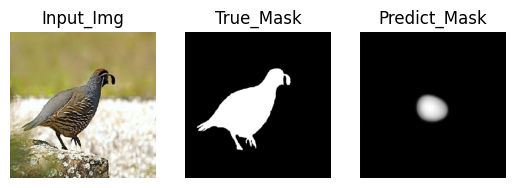

1/1 [==============================] - 0s 28ms/step


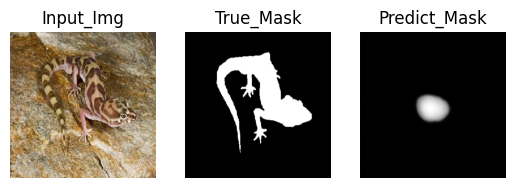

1/1 [==============================] - 0s 29ms/step


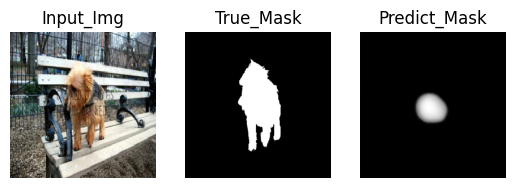

1/1 [==============================] - 0s 41ms/step


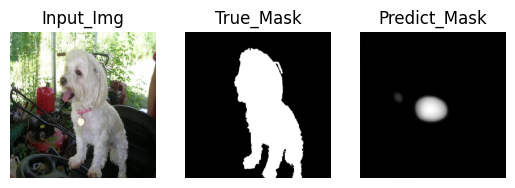

In [20]:
for img, mask in valid_data:
    pred_mask = basnet_model.predict(img)
    display_img([img[0], mask[0], normalize_output(pred_mask[0][0])])

In paper BASNet was trained on DUTS-TR dataset, which has 10553 images. Model was trained for 400k
iterations with a batch size of eight and without a validation dataset. After training model was
evaluated on DUTS-TE dataset and achieved a mean absolute error of `0.042`.

Since BASNet is a deep model and cannot be trained in a short amount of time which is a
requirement for keras example notebook, so we will load pretrained weights from [here](https://github.com/hamidriasat/BASNet/tree/basnet_keras)
to show model prediction. Due to computer power limitation this model was trained for 120k
iterations but it still demonstrates its capabilities. For further details about
trainings parameters please check given link.

In [21]:
!gdown 1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg

Downloading...
From (original): https://drive.google.com/uc?id=1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg
From (redirected): https://drive.google.com/uc?id=1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg&confirm=t&uuid=426d6bdc-550c-4132-945f-7bf539184084
To: /content/basnet_weights.h5
100% 436M/436M [00:03<00:00, 123MB/s]


In [23]:
basnet_model.load_weights("/content/basnet_weights.h5")

1/1 [==============================] - 0s 44ms/step


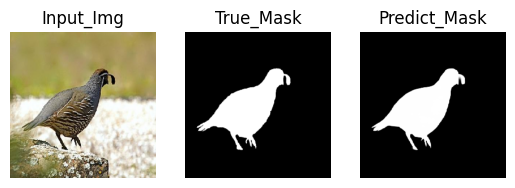

1/1 [==============================] - 0s 28ms/step


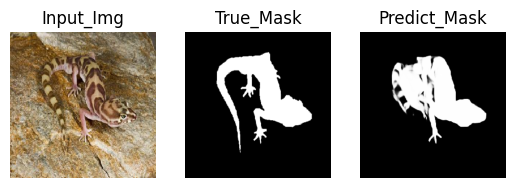

1/1 [==============================] - 0s 27ms/step


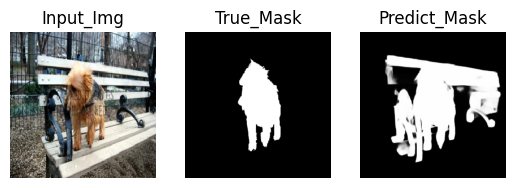

1/1 [==============================] - 0s 37ms/step


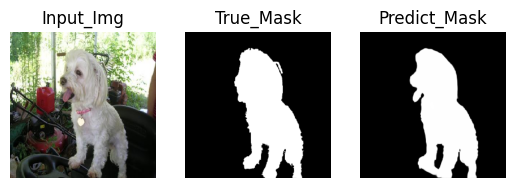

In [26]:
for img, mask in valid_data:
    pred_mask = basnet_model.predict(img)
    display_img([img[0], mask[0], normalize_output(pred_mask[0][0])])